# **PG sampling (иерархическая модель Θ_H не фиксированы)**

In [ ]:
install.packages("BayesLogit")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1]  0.3993974 -2.1169003  0.6366091  2.9391780  0.6961459  0.4796535  0.2866942
[8]  0.4293538

[1]  0.97451877 -0.62368555  1.29383335  0.09383203  1.16461781 -0.64427701
[7] -0.06461920  0.31528348

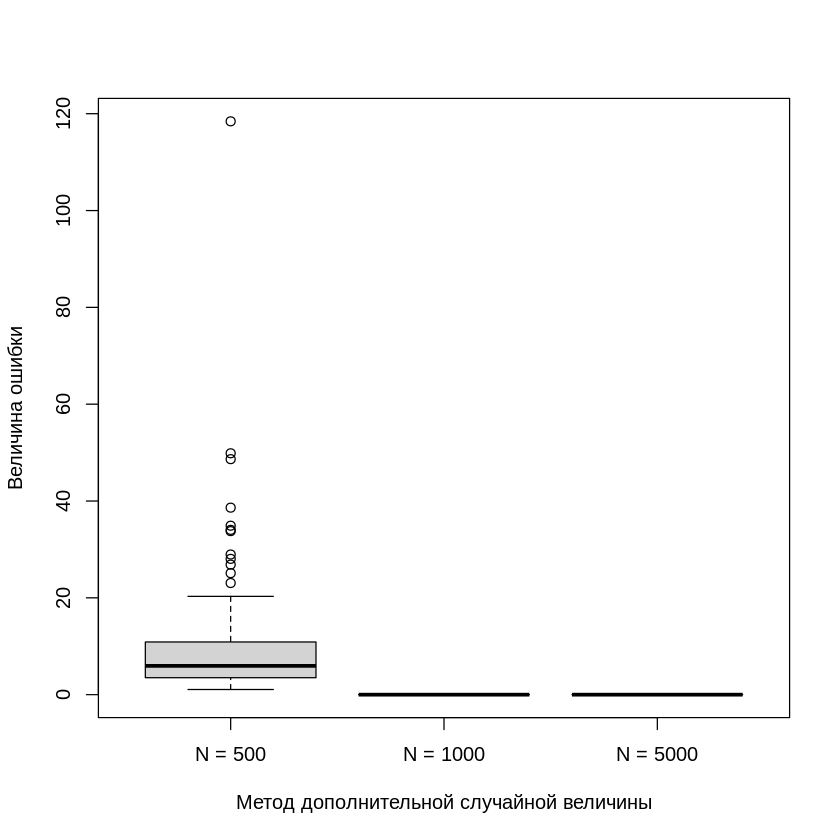

In [ ]:
library("MASS")
library("BayesLogit")
d = 2
n = 500
M = 100
r = 3

E = rep(0,M)
Z = matrix(0,M,3)
t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1


for(N in c(500)){
  for(m in 1:M){
    X = matrix(rnorm(d*n),n,d)
    #Параметры
    w_0 = rnorm(1, mu_w_0, sqrt(1/lambda_w_0))
    lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
    mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))
    w = rnorm(d, mu_w, sqrt(1/lambda_w))
    lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
    mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))
    v = matrix(rnorm((d*r), mu_v, sqrt(1/lambda_v)),d,r,byrow=TRUE)

    Theta_teor = c(w_0, w, c(t(v)))

    Theta_H_teor = c(lambda_w, mu_w, lambda_v, mu_v)

    SaveResults<- matrix(0,N,d+1+d*r)

    doudle_Sum_teor1 = 0.5 * rowSums((X%*%v)^2 - (X^2)%*%(v^2))
    p = 1 /(1 + exp(-(w_0 + X %*%w + doudle_Sum_teor1)))
    y = rbinom(n,1,p)
    k = y - 1/2

    mu_w_new = 0
    mu_v_new = rep(0, r)
    lambda_v_new = c()

    Theta_0 = 0
    Theta_w = rep(0, d)
    Theta_v = rep(0, d*r)
    Theta = c(Theta_0, Theta_w, Theta_v)

    Theta_v_matrix = t(matrix(Theta_v, r, d))
    doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

    Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

    Q = matrix(0,n,r)
    for (u in 1:n){
      for (f in 1:r){
        Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
      }
    }

    for(i in 1:N){
      #Обновление гиперпараметра lambda_w
      alpha_hat_lambda_w = d/2 + 1/2 + alpha_lambda
      beta_hat_lambda_w = 1/2 * (sum((Theta_w - mu_w_new)^2)) + gamma_0/2 * (mu_w_new - mu_0)^2 + beta_lambda

      lambda_w_new = rgamma(1, shape = alpha_hat_lambda_w, rate = beta_hat_lambda_w)

      #Обновление гиперпараметра mu_w
      sigma_hat_mu_w = 1/((d+gamma_0)*lambda_w_new)
      mu_hat_mu_w = sigma_hat_mu_w * lambda_w_new * (sum(Theta_w) + gamma_0*mu_0)

      mu_w_new = rnorm(1,  mu_hat_mu_w, sqrt(sigma_hat_mu_w))

      #Обновление гиперпараметра lambda_v
      for (f in 1:r){
        alpha_hat_lambda_v = d/2 + 1/2 + alpha_lambda
        beta_hat_lambda_v = 1/2 * (sum((Theta_v_matrix[,f] - mu_v_new[f])^2)) + gamma_0/2 * (mu_v_new[f] - mu_0)^2 + beta_lambda

        lambda_v_new[f] = rgamma(1, shape = alpha_hat_lambda_v, rate = beta_hat_lambda_v)

        #Обновление гиперпараметров mu_v_s
        sigma_hat_mu_v = 1/((d+gamma_0)*lambda_v_new[f])
        mu_hat_mu_v = sigma_hat_mu_w * lambda_v_new[f]*(sum(Theta_v_matrix[,f]) + gamma_0*mu_0)

        mu_v_new[f] = rnorm(1,  mu_hat_mu_v, sqrt(sigma_hat_mu_v))
      }

      Theta_H = c(lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

      omega = rpg(n, 1, Y)

      #Обновление w_0   (h_w_0(x) = 1)
      sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
      mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

      w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
      Y = Y + (w_0_new - Theta_0)
      Theta_0 = w_0_new

      #Обновление w   (h_w_j(x) = x_j)
      for(j in 1:d){
        sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w_new)
        mu_hat_w = sigma_hat_w * (lambda_w_new * mu_w_new + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

        w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
        Y = Y + (w_new - Theta_w[j])*X[,j]
        Theta_w[j] = w_new
      }

      #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
      for(f in 1:r){
        for(j in 1:d){
          h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
          sigma_hat_v = 1/(sum(omega * h^2) + lambda_v_new[f])
          mu_hat_v = sigma_hat_v * (lambda_v_new[f] * mu_v_new[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

          v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
          Y = Y + (v_new - Theta_v_matrix[j,f])*h
          Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
          Theta_v_matrix[j,f] = v_new
        }
      }
      Theta_v = c(t(Theta_v_matrix))
      Theta = c(Theta_0, Theta_w, Theta_v)

      SaveResults[i,] <-Theta
    }
    Theta_mean <- colMeans(SaveResults)
    E[m] = sqrt(sum((Theta_teor - Theta_mean)^2))
  }
  Z[,t] = E
  t=t+1
}
boxplot(Z,  names = c("N = 500", "N = 1000", "N = 5000"), ylab = "Величина ошибки", xlab = "Метод дополнительной случайной величины")
Theta_H_teor
Theta_H

In [ ]:
    d=2
    r=3
    Theta_0 = 0
    Theta_w = rep(0, d)
    Theta_v = rep(0, d*r)
    Theta = c(Theta_0, Theta_w, Theta_v)
    Theta_v

[1] 0 0 0 0 0 0

# **PG sampling (иерархическая модель Θ_H фиксированы)**

[1]  0.43627665 -1.57615116  0.74477372  1.01838124  0.03718623  1.04612609
[7] -3.55373350  2.73190356

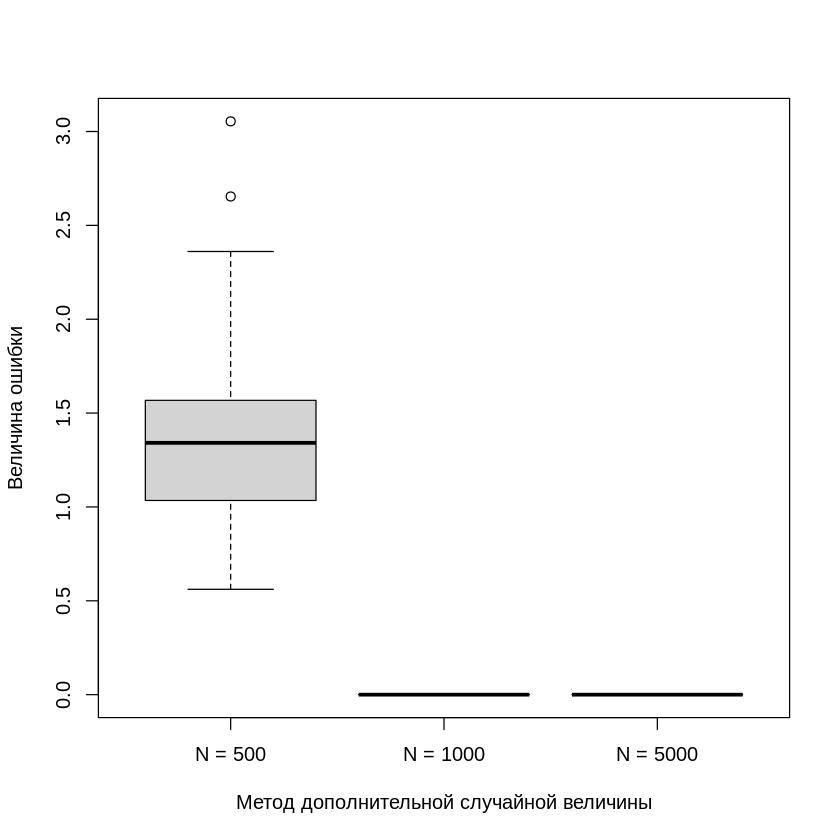

In [ ]:
library("MASS")
library("BayesLogit")
d = 2
n = 500
M = 100
r = 3

E = rep(0,M)
Z = matrix(0,M,3)
t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1


for(N in c(500)){
  for(m in 1:M){
    X = matrix(rnorm(d*n),n,d)
    #Параметры
    w_0 = rnorm(1, mu_w_0, sqrt(1/lambda_w_0))
    lambda_w = 7                                                  #rgamma(1, shape = alpha_lambda, rate = beta_lambda)
    mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))
    w = rnorm(d, mu_w, sqrt(1/lambda_w))
    lambda_v = c(3,5,2)                                           #rgamma(r, shape = alpha_lambda, rate = beta_lambda)
    mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))
    v = matrix(rnorm((d*r), mu_v, sqrt(1/lambda_v)),d,r,byrow=TRUE)

    Theta_teor = c(w_0, w, c(t(v)))

    SaveResults<- matrix(0,N,d+1+d*r)

    doudle_Sum_teor1 = 0.5 * rowSums((X%*%v)^2 - (X^2)%*%(v^2))
    p = 1 /(1 + exp(-(w_0 + X %*%w + doudle_Sum_teor1)))
    y = rbinom(n,1,p)
    k = y - 1/2


    Theta_0 = 0
    Theta_w = rep(0, d)
    #Theta_v = rep(0, d*r)
    Theta_v = rnorm((d*r))

    Theta = c(Theta_0, Theta_w, Theta_v)

    Theta_v_matrix = t(matrix(Theta_v, r, d))
    doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

    Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

    Q = matrix(0,n,r)
    for (u in 1:n){
      for (f in 1:r){
        Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
      }
    }

    for(i in 1:N){
      omega = rpg(n, 1, Y)

      #Обновление w_0   (h_w_0(x) = 1)
      sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
      mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

      w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
      Y = Y + (w_0_new - Theta_0)
      Theta_0 = w_0_new

      #Обновление w   (h_w_j(x) = x_j)
      for(j in 1:d){
        sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w)
        mu_hat_w = sigma_hat_w * (lambda_w * mu_w + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

        w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
        Y = Y + (w_new - Theta_w[j])*X[,j]
        Theta_w[j] = w_new
      }

      #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
      for(f in 1:r){
        for(j in 1:d){
          h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
          sigma_hat_v = 1/(sum(omega * h^2) + lambda_v[f])
          mu_hat_v = sigma_hat_v * (lambda_v[f] * mu_v[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

          v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
          Y = Y + (v_new - Theta_v_matrix[j,f])*h
          Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
          Theta_v_matrix[j,f] = v_new
        }
      }
      Theta_v = c(t(Theta_v_matrix))
      Theta = c(Theta_0, Theta_w, Theta_v)

      SaveResults[i,] <-Theta
    }
    Theta_mean <- colMeans(SaveResults)
    E[m] = sqrt(sum((Theta_teor - Theta_mean)^2))
  }
  Z[,t] = E
  t=t+1
}
boxplot(Z,  names = c("N = 500", "N = 1000", "N = 5000"), ylab = "Величина ошибки", xlab = "Метод дополнительной случайной величины")
Theta_H

# **Datasets Θ_H не фиксированы**

In [ ]:
install.packages("PRROC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Pima Indians Diabetes Dataset**

[1] 0.8077862

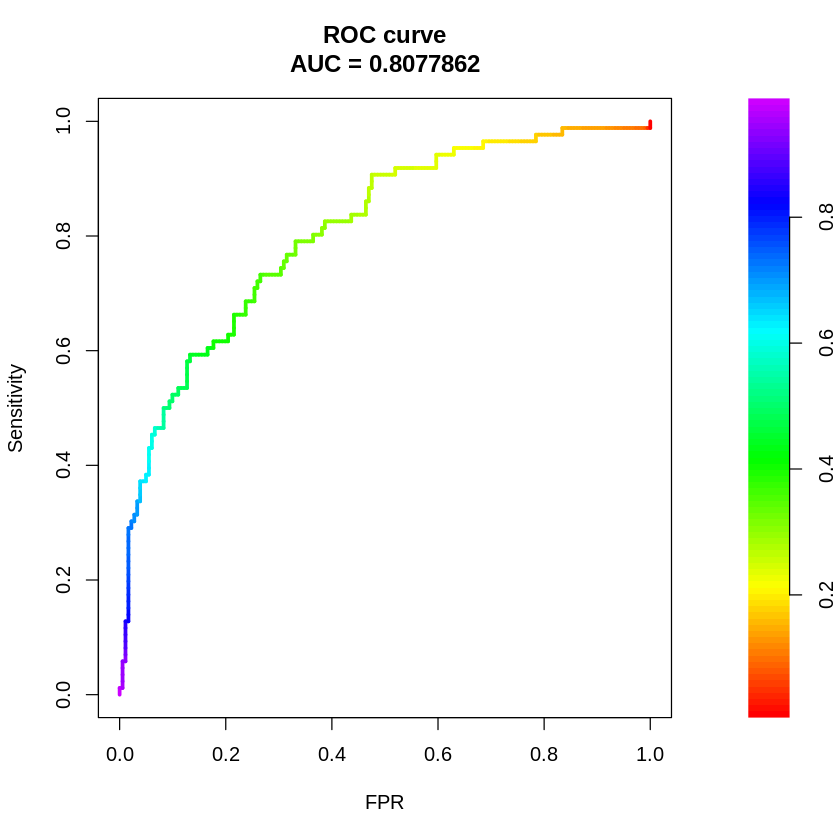

In [ ]:
library("MASS")
library("BayesLogit")
library("PRROC")
library(data.table)

data <- fread("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=TRUE)
data = as.matrix(data)

X = data[1:500,1:8]
y = data[1:500,9]

d = ncol(X)
n=500
r = 3
N = 100

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

SaveResults<- matrix(0,N,d+1+d*r)
k = y - 1/2

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_v_new = c()

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Theta = c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix = t(matrix(Theta_v, r, d))
doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

Q = matrix(0,n,r)
for (u in 1:n){
  for (f in 1:r){
    Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
  }
}

for(i in 1:N){
  #Обновление гиперпараметра lambda_w
  alpha_hat_lambda_w = d/2 + 1/2 + alpha_lambda
  beta_hat_lambda_w = 1/2 * (sum((Theta_w - mu_w_new)^2)) + gamma_0/2 * (mu_w_new - mu_0)^2 + beta_lambda

  lambda_w_new = rgamma(1, shape = alpha_hat_lambda_w, rate = beta_hat_lambda_w)

  #Обновление гиперпараметра mu_w
  sigma_hat_mu_w = 1/((d+gamma_0)*lambda_w_new)
  mu_hat_mu_w = sigma_hat_mu_w * lambda_w_new * (sum(Theta_w) + gamma_0*mu_0)

  mu_w_new = rnorm(1,  mu_hat_mu_w, sqrt(sigma_hat_mu_w))

  #Обновление гиперпараметра lambda_v
  for (f in 1:r){
    alpha_hat_lambda_v = d/2 + 1/2 + alpha_lambda
    beta_hat_lambda_v = 1/2 * (sum((Theta_v_matrix[,f] - mu_v_new[f])^2)) + gamma_0/2 * (mu_v_new[f] - mu_0)^2 + beta_lambda

    lambda_v_new[f] = rgamma(1, shape = alpha_hat_lambda_v, rate = beta_hat_lambda_v)

    #Обновление гиперпараметров mu_v_s
    sigma_hat_mu_v = 1/((d+gamma_0)*lambda_v_new[f])
    mu_hat_mu_v = sigma_hat_mu_w * lambda_v_new[f]*(sum(Theta_v_matrix[,f]) + gamma_0*mu_0)

    mu_v_new[f] = rnorm(1,  mu_hat_mu_v, sqrt(sigma_hat_mu_v))
  }

  Theta_H = c(lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

  omega = rpg(n, 1, Y)

  #Обновление w_0   (h_w_0(x) = 1)
  sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
  mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

  w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y = Y + (w_0_new - Theta_0)
  Theta_0 = w_0_new

  #Обновление w   (h_w_j(x) = x_j)
  for(j in 1:d){
    sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w_new)
    mu_hat_w = sigma_hat_w * (lambda_w_new * mu_w_new + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

    w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
    Y = Y + (w_new - Theta_w[j])*X[,j]
    Theta_w[j] = w_new
  }

  #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
  for(f in 1:r){
    for(j in 1:d){
      h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
      sigma_hat_v = 1/(sum(omega * h^2) + lambda_v_new[f])
      mu_hat_v = sigma_hat_v * (lambda_v_new[f] * mu_v_new[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

      v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
      Y = Y + (v_new - Theta_v_matrix[j,f])*h
      Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
      Theta_v_matrix[j,f] = v_new
    }
  }
  Theta_v = c(t(Theta_v_matrix))
  Theta = c(Theta_0, Theta_w, Theta_v)

  SaveResults[i,] <-Theta
}
Theta_mean <- colMeans(SaveResults)
V = matrix(Theta_mean[-(1:(d+1))],d,r,byrow=TRUE)

X1 = data[501:767,1:8]
y1 = data[501:767,9]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(Theta_mean[1] + X1 %*%Theta_mean[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Sonar Dataset**

[1] 0.8138298

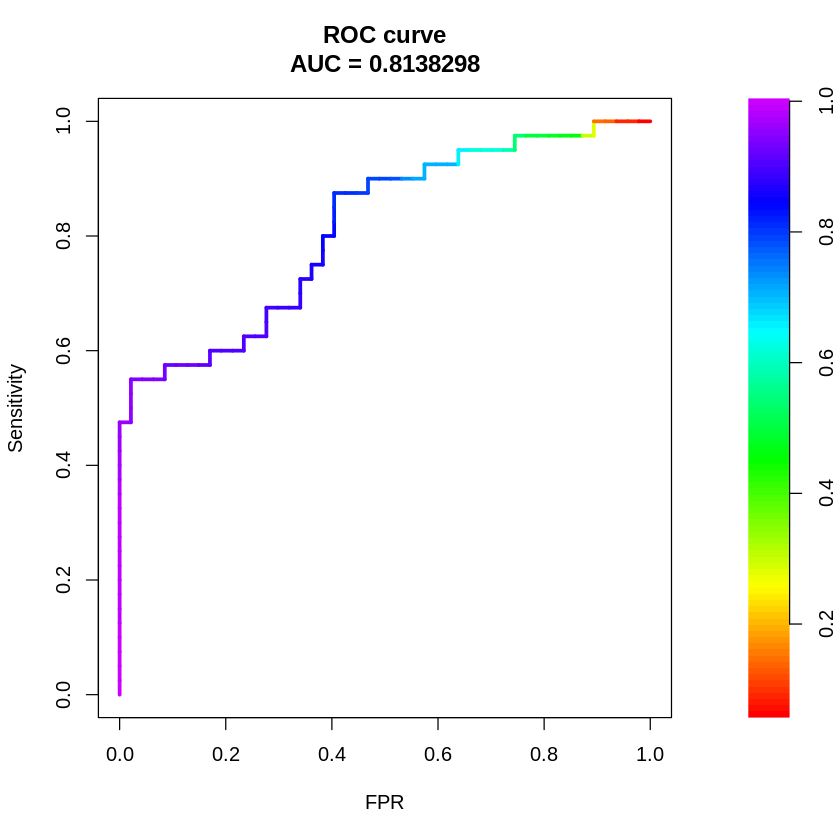

In [ ]:
library("MASS")
library("BayesLogit")
library(data.table)

data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=TRUE)


ind = sample(1:207)
data = data[ind,]

n = 120
r = 2
N = 100

X = data[1:n,1:60]
X = as.matrix(X)
y = (data[1:n,61]=='R') *1
d = ncol(X)

t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

SaveResults<- matrix(0,N,d+1+d*r)
k = y - 1/2

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_v_new = c()

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Theta = c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix = t(matrix(Theta_v, r, d))
doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

Q = matrix(0,n,r)
for (u in 1:n){
  for (f in 1:r){
    Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
  }
}

for(i in 1:N){
  #Обновление гиперпараметра lambda_w
  alpha_hat_lambda_w = d/2 + 1/2 + alpha_lambda
  beta_hat_lambda_w = 1/2 * (sum((Theta_w - mu_w_new)^2)) + gamma_0/2 * (mu_w_new - mu_0)^2 + beta_lambda

  lambda_w_new = rgamma(1, shape = alpha_hat_lambda_w, rate = beta_hat_lambda_w)

  #Обновление гиперпараметра mu_w
  sigma_hat_mu_w = 1/((d+gamma_0)*lambda_w_new)
  mu_hat_mu_w = sigma_hat_mu_w * lambda_w_new * (sum(Theta_w) + gamma_0*mu_0)

  mu_w_new = rnorm(1,  mu_hat_mu_w, sqrt(sigma_hat_mu_w))

  #Обновление гиперпараметра lambda_v
  for (f in 1:r){
    alpha_hat_lambda_v = d/2 + 1/2 + alpha_lambda
    beta_hat_lambda_v = 1/2 * (sum((Theta_v_matrix[,f] - mu_v_new[f])^2)) + gamma_0/2 * (mu_v_new[f] - mu_0)^2 + beta_lambda

    lambda_v_new[f] = rgamma(1, shape = alpha_hat_lambda_v, rate = beta_hat_lambda_v)

    #Обновление гиперпараметров mu_v_s
    sigma_hat_mu_v = 1/((d+gamma_0)*lambda_v_new[f])
    mu_hat_mu_v = sigma_hat_mu_w * lambda_v_new[f]*(sum(Theta_v_matrix[,f]) + gamma_0*mu_0)

    mu_v_new[f] = rnorm(1,  mu_hat_mu_v, sqrt(sigma_hat_mu_v))
  }

  Theta_H = c(lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

  omega = rpg(n, 1, Y)

  #Обновление w_0   (h_w_0(x) = 1)
  sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
  mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

  w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y = Y + (w_0_new - Theta_0)
  Theta_0 = w_0_new

  #Обновление w   (h_w_j(x) = x_j)
  for(j in 1:d){
    sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w_new)
    mu_hat_w = sigma_hat_w * (lambda_w_new * mu_w_new + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

    w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
    Y = Y + (w_new - Theta_w[j])*X[,j]
    Theta_w[j] = w_new
  }

  #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
  for(f in 1:r){
    for(j in 1:d){
      h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
      sigma_hat_v = 1/(sum(omega * h^2) + lambda_v_new[f])
      mu_hat_v = sigma_hat_v * (lambda_v_new[f] * mu_v_new[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

      v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
      Y = Y + (v_new - Theta_v_matrix[j,f])*h
      Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
      Theta_v_matrix[j,f] = v_new
    }
  }
  Theta_v = c(t(Theta_v_matrix))
  Theta = c(Theta_0, Theta_w, Theta_v)

  SaveResults[i,] <-Theta
}
Theta_mean <- colMeans(SaveResults)
V = matrix(Theta_mean[-(1:(d+1))],d,r,byrow=TRUE)
X1 = data[121:207,1:60]
X1 =as.matrix(X1)
y1 = (data[121:207,61]=='R')*1
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(Theta_mean[1] + X1 %*%Theta_mean[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Australian Credit Approval DataSet**

[1] 0.9386694

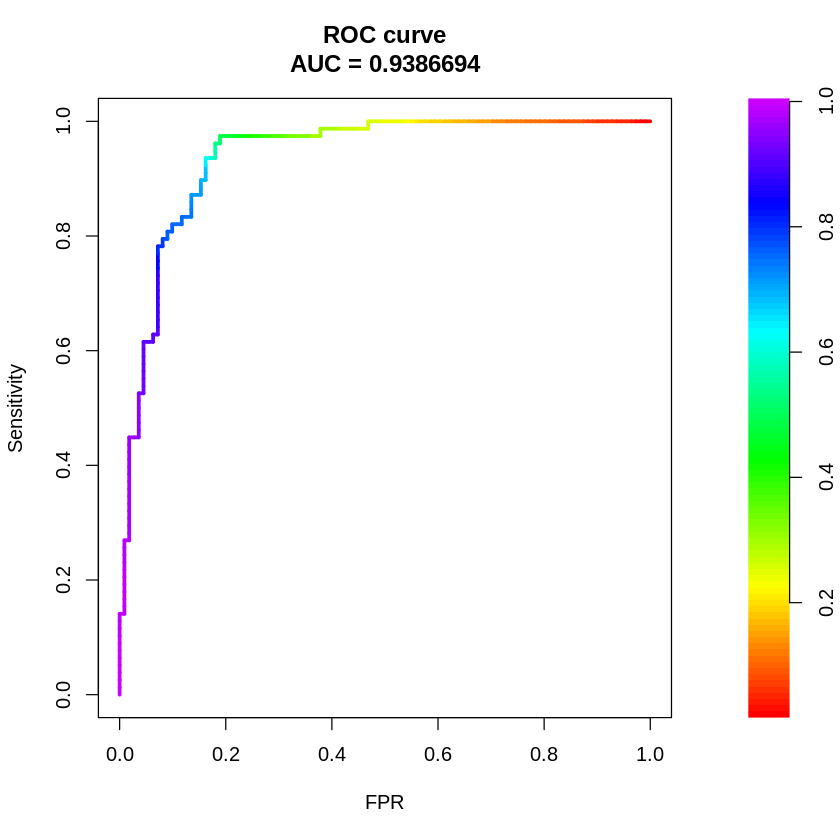

In [ ]:
library("PRROC")
library("MASS")
library("BayesLogit")
library(data.table)
data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat", header = TRUE)
data = as.matrix(na.omit(data))

n = 500
y = data[1:n,15]
X = data[1:n,1:14]

d = ncol(X)

r = 3
N = 100

t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

SaveResults<- matrix(0,N,d+1+d*r)
k = y - 1/2

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_v_new = c()

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Theta = c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix = t(matrix(Theta_v, r, d))
doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

Q = matrix(0,n,r)
for (u in 1:n){
  for (f in 1:r){
    Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
  }
}

for(i in 1:N){
  #Обновление гиперпараметра lambda_w
  alpha_hat_lambda_w = d/2 + 1/2 + alpha_lambda
  beta_hat_lambda_w = 1/2 * (sum((Theta_w - mu_w_new)^2)) + gamma_0/2 * (mu_w_new - mu_0)^2 + beta_lambda

  lambda_w_new = rgamma(1, shape = alpha_hat_lambda_w, rate = beta_hat_lambda_w)

  #Обновление гиперпараметра mu_w
  sigma_hat_mu_w = 1/((d+gamma_0)*lambda_w_new)
  mu_hat_mu_w = sigma_hat_mu_w * lambda_w_new * (sum(Theta_w) + gamma_0*mu_0)

  mu_w_new = rnorm(1,  mu_hat_mu_w, sqrt(sigma_hat_mu_w))

  #Обновление гиперпараметра lambda_v
  for (f in 1:r){
    alpha_hat_lambda_v = d/2 + 1/2 + alpha_lambda
    beta_hat_lambda_v = 1/2 * (sum((Theta_v_matrix[,f] - mu_v_new[f])^2)) + gamma_0/2 * (mu_v_new[f] - mu_0)^2 + beta_lambda

    lambda_v_new[f] = rgamma(1, shape = alpha_hat_lambda_v, rate = beta_hat_lambda_v)

    #Обновление гиперпараметров mu_v_s
    sigma_hat_mu_v = 1/((d+gamma_0)*lambda_v_new[f])
    mu_hat_mu_v = sigma_hat_mu_w * lambda_v_new[f]*(sum(Theta_v_matrix[,f]) + gamma_0*mu_0)

    mu_v_new[f] = rnorm(1,  mu_hat_mu_v, sqrt(sigma_hat_mu_v))
  }

  Theta_H = c(lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

  omega = rpg(n, 1, Y)

  #Обновление w_0   (h_w_0(x) = 1)
  sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
  mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

  w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y = Y + (w_0_new - Theta_0)
  Theta_0 = w_0_new

  #Обновление w   (h_w_j(x) = x_j)
  for(j in 1:d){
    sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w_new)
    mu_hat_w = sigma_hat_w * (lambda_w_new * mu_w_new + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

    w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
    Y = Y + (w_new - Theta_w[j])*X[,j]
    Theta_w[j] = w_new
  }

  #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
  for(f in 1:r){
    for(j in 1:d){
      h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
      sigma_hat_v = 1/(sum(omega * h^2) + lambda_v_new[f])
      mu_hat_v = sigma_hat_v * (lambda_v_new[f] * mu_v_new[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

      v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
      Y = Y + (v_new - Theta_v_matrix[j,f])*h
      Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
      Theta_v_matrix[j,f] = v_new
    }
  }
  Theta_v = c(t(Theta_v_matrix))
  Theta = c(Theta_0, Theta_w, Theta_v)

  SaveResults[i,] <-Theta
}
Theta_mean <- colMeans(SaveResults)
V = matrix(Theta_mean[-(1:(d+1))],d,r,byrow=TRUE)
X1 = data[501:689,1:14]
y1 = data[501:689,15]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(Theta_mean[1] + X1 %*%Theta_mean[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Banknote Dataset**

[1] 0.9940876

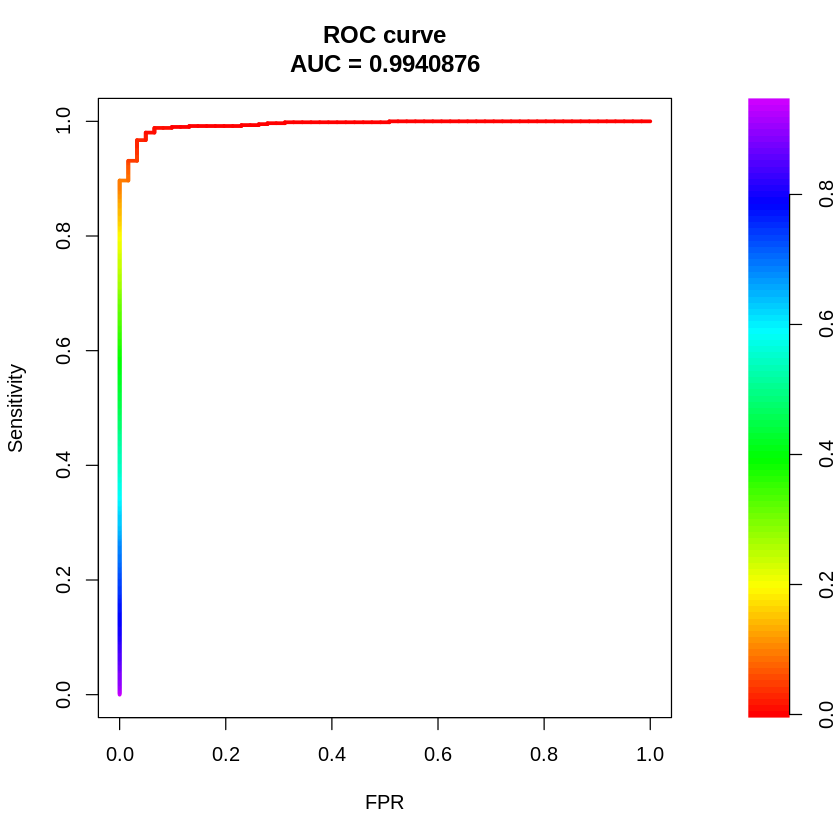

In [ ]:
library("PRROC")
library("MASS")
library("BayesLogit")
library(data.table)

data <- fread("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", header = TRUE)
data = as.matrix(data)

X = data[1:700,1:4]
y = data[1:700,5]

d = ncol(X)
n=700
r = 2
N = 100

t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

SaveResults<- matrix(0,N,d+1+d*r)
k = y - 1/2

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_v_new = c()

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Theta = c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix = t(matrix(Theta_v, r, d))
doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

Q = matrix(0,n,r)
for (u in 1:n){
  for (f in 1:r){
    Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
  }
}

for(i in 1:N){
  #Обновление гиперпараметра lambda_w
  alpha_hat_lambda_w = d/2 + 1/2 + alpha_lambda
  beta_hat_lambda_w = 1/2 * (sum((Theta_w - mu_w_new)^2)) + gamma_0/2 * (mu_w_new - mu_0)^2 + beta_lambda

  lambda_w_new = rgamma(1, shape = alpha_hat_lambda_w, rate = beta_hat_lambda_w)

  #Обновление гиперпараметра mu_w
  sigma_hat_mu_w = 1/((d+gamma_0)*lambda_w_new)
  mu_hat_mu_w = sigma_hat_mu_w * lambda_w_new * (sum(Theta_w) + gamma_0*mu_0)

  mu_w_new = rnorm(1,  mu_hat_mu_w, sqrt(sigma_hat_mu_w))

  #Обновление гиперпараметра lambda_v
  for (f in 1:r){
    alpha_hat_lambda_v = d/2 + 1/2 + alpha_lambda
    beta_hat_lambda_v = 1/2 * (sum((Theta_v_matrix[,f] - mu_v_new[f])^2)) + gamma_0/2 * (mu_v_new[f] - mu_0)^2 + beta_lambda

    lambda_v_new[f] = rgamma(1, shape = alpha_hat_lambda_v, rate = beta_hat_lambda_v)

    #Обновление гиперпараметров mu_v_s
    sigma_hat_mu_v = 1/((d+gamma_0)*lambda_v_new[f])
    mu_hat_mu_v = sigma_hat_mu_w * lambda_v_new[f]*(sum(Theta_v_matrix[,f]) + gamma_0*mu_0)

    mu_v_new[f] = rnorm(1,  mu_hat_mu_v, sqrt(sigma_hat_mu_v))
  }

  Theta_H = c(lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

  omega = rpg(n, 1, Y)

  #Обновление w_0   (h_w_0(x) = 1)
  sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
  mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

  w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y = Y + (w_0_new - Theta_0)
  Theta_0 = w_0_new

  #Обновление w   (h_w_j(x) = x_j)
  for(j in 1:d){
    sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w_new)
    mu_hat_w = sigma_hat_w * (lambda_w_new * mu_w_new + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

    w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
    Y = Y + (w_new - Theta_w[j])*X[,j]
    Theta_w[j] = w_new
  }

  #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
  for(f in 1:r){
    for(j in 1:d){
      h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
      sigma_hat_v = 1/(sum(omega * h^2) + lambda_v_new[f])
      mu_hat_v = sigma_hat_v * (lambda_v_new[f] * mu_v_new[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

      v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
      Y = Y + (v_new - Theta_v_matrix[j,f])*h
      Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
      Theta_v_matrix[j,f] = v_new
    }
  }
  Theta_v = c(t(Theta_v_matrix))
  Theta = c(Theta_0, Theta_w, Theta_v)

  SaveResults[i,] <-Theta
}
Theta_mean <- colMeans(SaveResults)
V = matrix(Theta_mean[-(1:(d+1))],d,r,byrow=TRUE)
X1 = data[701:1371,1:4]
y1 = data[701:1371,5]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(Theta_mean[1] + X1 %*%Theta_mean[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

# **Datasets Θ_H фиксированы**

In [ ]:
install.packages("PRROC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Pima Indians Diabetes Dataset**

[1] 0.8160093

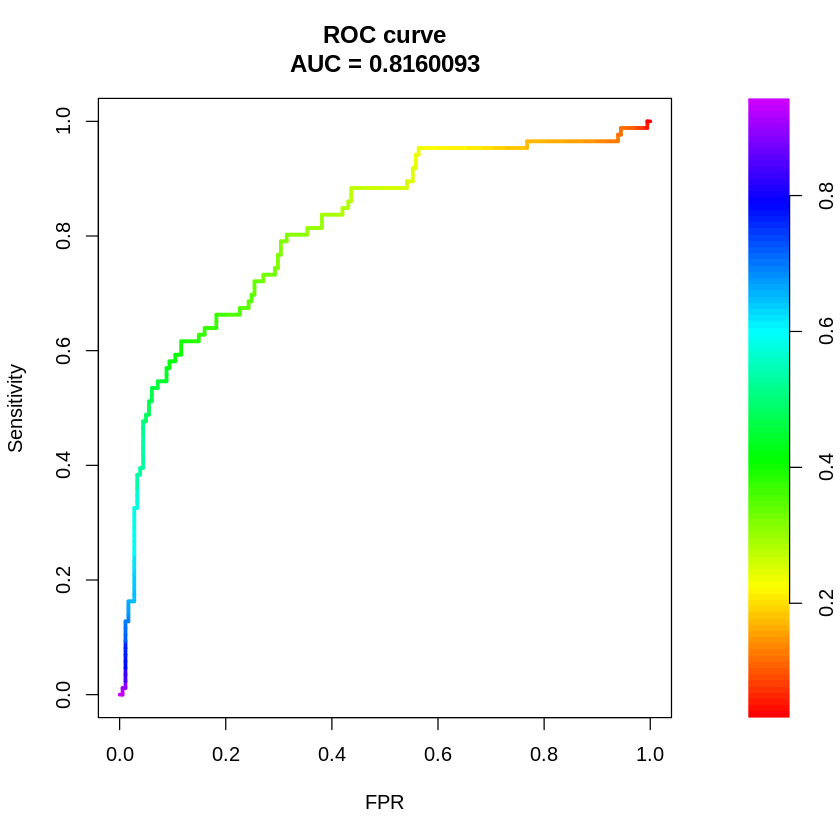

In [ ]:
library("MASS")
library("BayesLogit")
library("PRROC")
library(data.table)

data <- fread("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=TRUE)
data = as.matrix(data)

X = data[1:500,1:8]
y = data[1:500,9]

d = ncol(X)
n=500
r = 3
N = 100

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

SaveResults<- matrix(0,N,d+1+d*r)
k = y - 1/2

lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))

lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))


Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Theta = c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix = t(matrix(Theta_v, r, d))
doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

Q = matrix(0,n,r)
for (u in 1:n){
  for (f in 1:r){
    Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
  }
}

for(i in 1:N){
  omega = rpg(n, 1, Y)

  #Обновление w_0   (h_w_0(x) = 1)
  sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
  mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

  w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y = Y + (w_0_new - Theta_0)
  Theta_0 = w_0_new

  #Обновление w   (h_w_j(x) = x_j)
  for(j in 1:d){
    sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w)
    mu_hat_w = sigma_hat_w * (lambda_w * mu_w + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

    w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
    Y = Y + (w_new - Theta_w[j])*X[,j]
    Theta_w[j] = w_new
  }

  #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
  for(f in 1:r){
    for(j in 1:d){
      h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
      sigma_hat_v = 1/(sum(omega * h^2) + lambda_v[f])
      mu_hat_v = sigma_hat_v * (lambda_v[f] * mu_v[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

      v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
      Y = Y + (v_new - Theta_v_matrix[j,f])*h
      Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
      Theta_v_matrix[j,f] = v_new
    }
  }
  Theta_v = c(t(Theta_v_matrix))
  Theta = c(Theta_0, Theta_w, Theta_v)

  SaveResults[i,] <-Theta
}
Theta_mean <- colMeans(SaveResults)
V = matrix(Theta_mean[-(1:(d+1))],d,r,byrow=TRUE)

X1 = data[501:767,1:8]
y1 = data[501:767,9]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(Theta_mean[1] + X1 %*%Theta_mean[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Sonar Dataset**

[1] 0.7505319

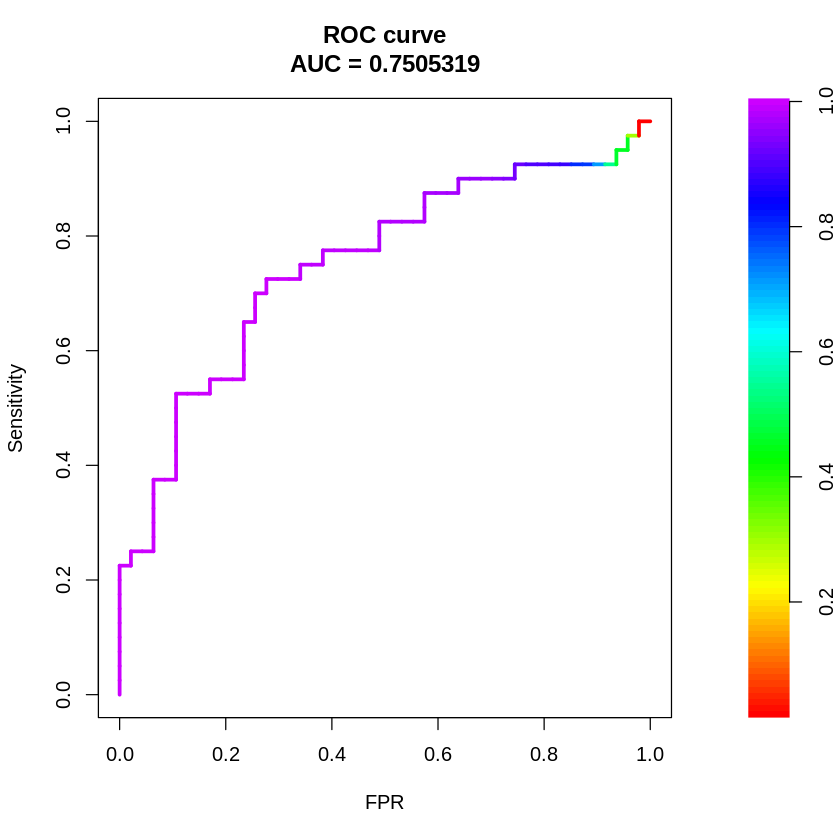

In [ ]:
library("MASS")
library("BayesLogit")
library(data.table)

data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=TRUE)


ind = sample(1:207)
data = data[ind,]

n = 120
r = 2
N = 100

X = data[1:n,1:60]
X = as.matrix(X)
y = (data[1:n,61]=='R') *1
d = ncol(X)

t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

SaveResults<- matrix(0,N,d+1+d*r)
k = y - 1/2

lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))

lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))


Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Theta = c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix = t(matrix(Theta_v, r, d))
doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

Q = matrix(0,n,r)
for (u in 1:n){
  for (f in 1:r){
    Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
  }
}

for(i in 1:N){
  omega = rpg(n, 1, Y)

  #Обновление w_0   (h_w_0(x) = 1)
  sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
  mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

  w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y = Y + (w_0_new - Theta_0)
  Theta_0 = w_0_new

  #Обновление w   (h_w_j(x) = x_j)
  for(j in 1:d){
    sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w)
    mu_hat_w = sigma_hat_w * (lambda_w * mu_w + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

    w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
    Y = Y + (w_new - Theta_w[j])*X[,j]
    Theta_w[j] = w_new
  }

  #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
  for(f in 1:r){
    for(j in 1:d){
      h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
      sigma_hat_v = 1/(sum(omega * h^2) + lambda_v[f])
      mu_hat_v = sigma_hat_v * (lambda_v[f] * mu_v[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

      v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
      Y = Y + (v_new - Theta_v_matrix[j,f])*h
      Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
      Theta_v_matrix[j,f] = v_new
    }
  }
  Theta_v = c(t(Theta_v_matrix))
  Theta = c(Theta_0, Theta_w, Theta_v)

  SaveResults[i,] <-Theta
}
Theta_mean <- colMeans(SaveResults)
V = matrix(Theta_mean[-(1:(d+1))],d,r,byrow=TRUE)

X1 = data[121:207,1:60]
X1 =as.matrix(X1)
y1 = (data[121:207,61]=='R')*1
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(Theta_mean[1] + X1 %*%Theta_mean[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Australian Credit Approval DataSet**

[1] 0.9424809

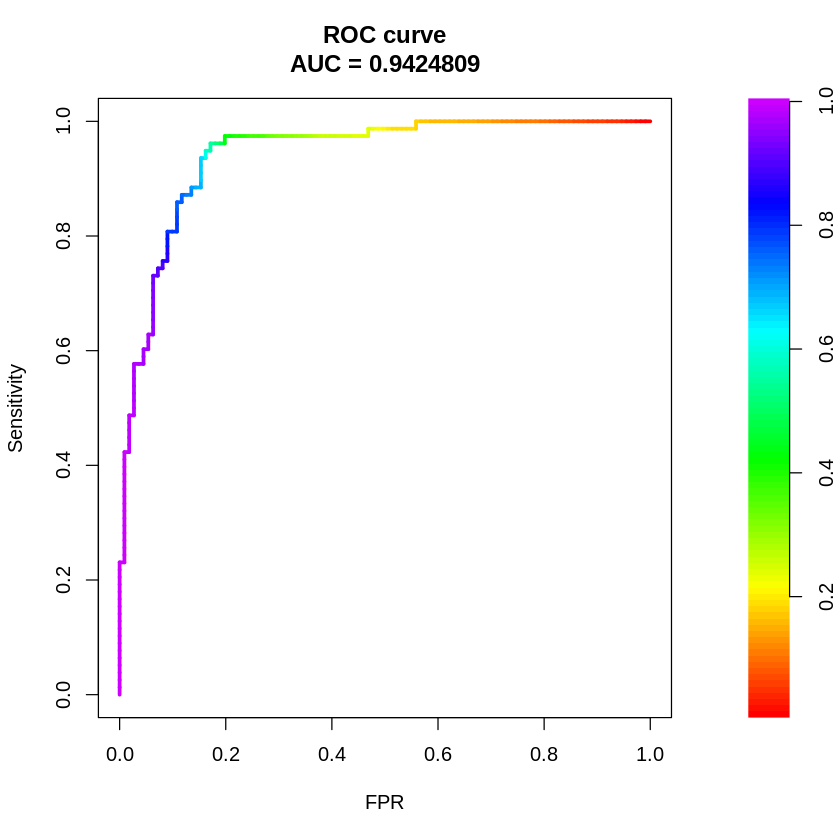

In [ ]:
library("PRROC")
library("MASS")
library("BayesLogit")
library(data.table)
data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat", header = TRUE)
data = as.matrix(na.omit(data))

n = 500
y = data[1:n,15]
X = data[1:n,1:14]

d = ncol(X)

r = 3
N = 100

t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

SaveResults<- matrix(0,N,d+1+d*r)
k = y - 1/2

lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))

lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))


Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Theta = c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix = t(matrix(Theta_v, r, d))
doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

Q = matrix(0,n,r)
for (u in 1:n){
  for (f in 1:r){
    Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
  }
}

for(i in 1:N){
  omega = rpg(n, 1, Y)

  #Обновление w_0   (h_w_0(x) = 1)
  sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
  mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

  w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y = Y + (w_0_new - Theta_0)
  Theta_0 = w_0_new

  #Обновление w   (h_w_j(x) = x_j)
  for(j in 1:d){
    sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w)
    mu_hat_w = sigma_hat_w * (lambda_w * mu_w + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

    w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
    Y = Y + (w_new - Theta_w[j])*X[,j]
    Theta_w[j] = w_new
  }

  #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
  for(f in 1:r){
    for(j in 1:d){
      h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
      sigma_hat_v = 1/(sum(omega * h^2) + lambda_v[f])
      mu_hat_v = sigma_hat_v * (lambda_v[f] * mu_v[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

      v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
      Y = Y + (v_new - Theta_v_matrix[j,f])*h
      Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
      Theta_v_matrix[j,f] = v_new
    }
  }
  Theta_v = c(t(Theta_v_matrix))
  Theta = c(Theta_0, Theta_w, Theta_v)

  SaveResults[i,] <-Theta
}
Theta_mean <- colMeans(SaveResults)
V = matrix(Theta_mean[-(1:(d+1))],d,r,byrow=TRUE)

X1 = data[501:689,1:14]
y1 = data[501:689,15]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(Theta_mean[1] + X1 %*%Theta_mean[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Banknote Dataset**

[1] 0.9395055

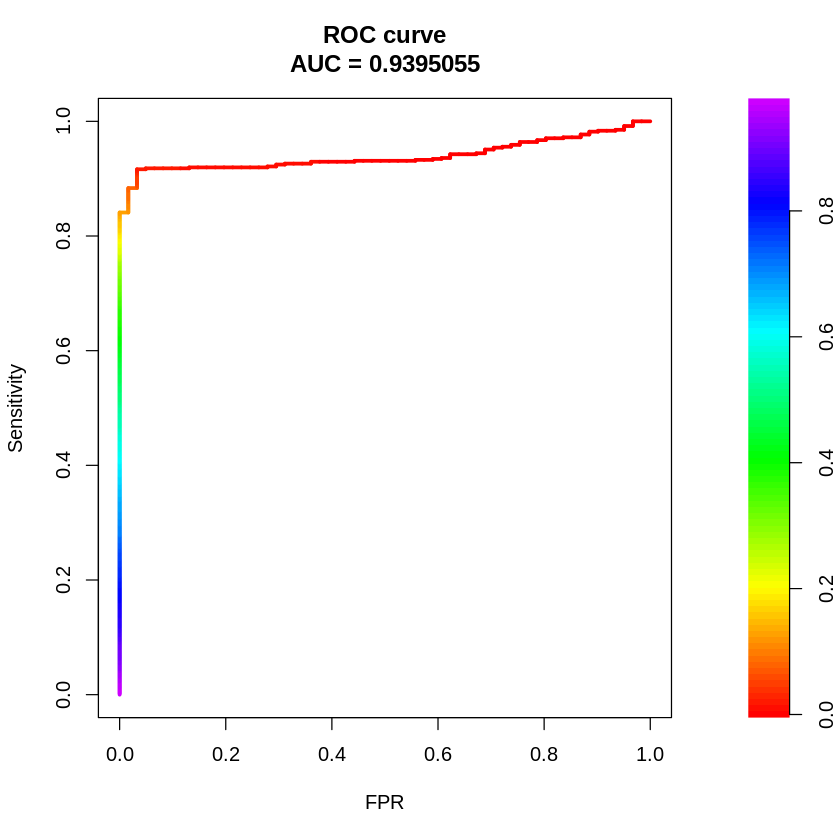

In [ ]:
library("PRROC")
library("MASS")
library("BayesLogit")
library(data.table)

data <- fread("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", header = TRUE)
data = as.matrix(data)

X = data[1:700,1:4]
y = data[1:700,5]

d = ncol(X)
n=700
r = 2
N = 100

t = 1

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

SaveResults<- matrix(0,N,d+1+d*r)
k = y - 1/2

lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))

lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Theta = c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix = t(matrix(Theta_v, r, d))
doudle_Sum_Theta = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))

Y = matrix(Theta_0 + X %*%Theta_w + doudle_Sum_Theta, n,1)

Q = matrix(0,n,r)
for (u in 1:n){
  for (f in 1:r){
    Q[u,f] = sum(Theta_v_matrix[,f]*X[u,])
  }
}

for(i in 1:N){
  omega = rpg(n, 1, Y)

  #Обновление w_0   (h_w_0(x) = 1)
  sigma_hat_w_0 = 1/(sum(omega) + lambda_w_0)
  mu_hat_w_0 = sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))

  w_0_new = rnorm(1,  mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y = Y + (w_0_new - Theta_0)
  Theta_0 = w_0_new

  #Обновление w   (h_w_j(x) = x_j)
  for(j in 1:d){
    sigma_hat_w = 1/(sum(omega * X[,j]^2) + lambda_w)
    mu_hat_w = sigma_hat_w * (lambda_w * mu_w + sum(k*X[,j]) - sum(omega * X[,j] * (Y - Theta_w[j]*X[,j])))

    w_new = rnorm(1,  mu_hat_w, sqrt(sigma_hat_w))
    Y = Y + (w_new - Theta_w[j])*X[,j]
    Theta_w[j] = w_new
  }

  #Обновление v   (h_v_jf(x) = x_j * q(x,f) - (x_j)^2*v_jf)
  for(f in 1:r){
    for(j in 1:d){
      h = X[,j]*Q[,f] - X[,j]^2 * Theta_v_matrix[j,f]
      sigma_hat_v = 1/(sum(omega * h^2) + lambda_v[f])
      mu_hat_v = sigma_hat_v * (lambda_v[f] * mu_v[f] + sum(k*h) - sum(omega * h * (Y - Theta_v_matrix[j,f]*h)))

      v_new = rnorm(1,  mu_hat_v, sqrt(sigma_hat_v))
      Y = Y + (v_new - Theta_v_matrix[j,f])*h
      Q[,f] = Q[,f] + (v_new - Theta_v_matrix[j,f])*X[,j]
      Theta_v_matrix[j,f] = v_new
    }
  }
  Theta_v = c(t(Theta_v_matrix))
  Theta = c(Theta_0, Theta_w, Theta_v)

  SaveResults[i,] <-Theta
}
Theta_mean <- colMeans(SaveResults)
V = matrix(Theta_mean[-(1:(d+1))],d,r,byrow=TRUE)

X1 = data[701:1371,1:4]
y1 = data[701:1371,5]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(Theta_mean[1] + X1 %*%Theta_mean[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

# **MovieLens**

In [ ]:
if (!require("Matrix")) install.packages("Matrix")
if (!require("MASS")) install.packages("MASS")
if (!require("BayesLogit")) install.packages("BayesLogit")
if (!require("PRROC")) install.packages("PRROC")

Loading required package: Matrix

Loading required package: MASS

Loading required package: BayesLogit

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘BayesLogit’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: PRROC

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘PRROC’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



признаки объектов

AUROC на тестовом наборе: 0.7626903 


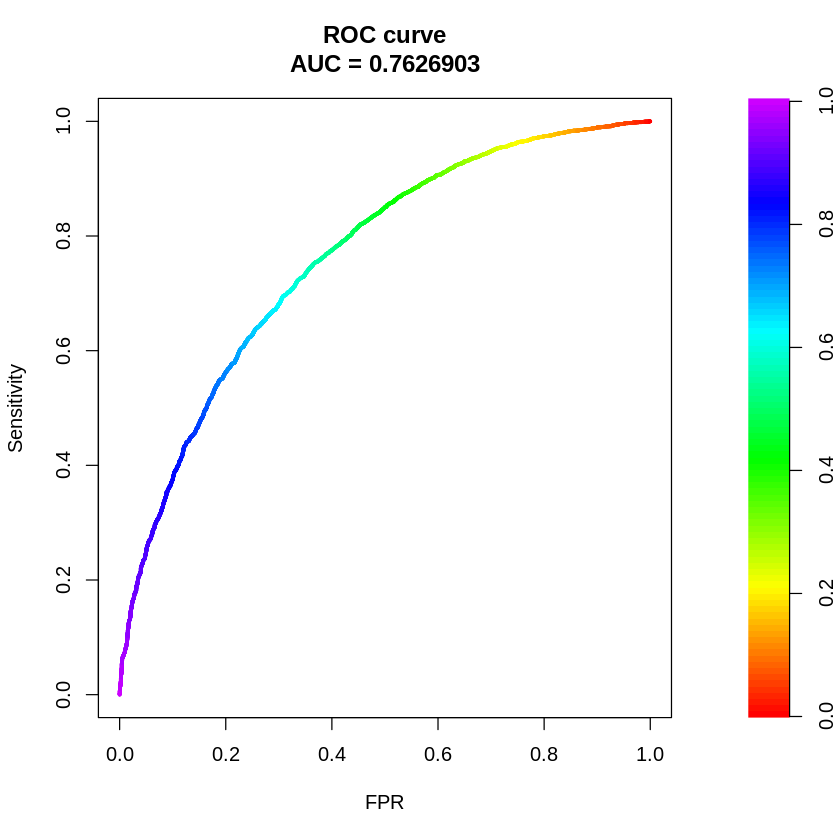

In [ ]:
library(Matrix)
library(MASS)
library(BayesLogit)
library(PRROC)

X <- readMM("/content/X_it.mm.mtx")
y <- as.vector(read.csv("/content/y_it.csv", header = FALSE)$V1)
X1 <- readMM("/content/X1_it.mm.mtx")
y1 <- as.vector(read.csv("/content/y1_it.csv", header = FALSE)$V1)

d <- ncol(X)
n <- nrow(X)
r <- 3
N <- 50

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

mu_0 <- 0
mu_w_0 <- 2
lambda_w_0 <- 3
gamma_0 <- 1
alpha_lambda <- 1
beta_lambda <- 1

t <- 1
SaveResults <- matrix(0, N, d + 1 + d * r)
k <- y - 1/2

lambda_w <- rgamma(1, shape = alpha_lambda, rate = beta_lambda)
mu_w <- rnorm(1, mu_0, sqrt(1/(gamma_0 * lambda_w)))
lambda_v <- rgamma(r, shape = alpha_lambda, rate = beta_lambda)
mu_v <- rnorm(r, mu_0, sqrt(1/(gamma_0 * lambda_v)))

Theta_0 <- 0
Theta_w <- rep(0, d)
Theta_v <- rep(0, d * r)
Theta <- c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix <- t(matrix(Theta_v, r, d))

doudle_Sum_Theta <- 0.5 * rowSums(( X %*% Theta_v_matrix)^2 - X^2 %*% Theta_v_matrix^2)

Y <- matrix(Theta_0 + X %*% Theta_w + doudle_Sum_Theta, n, 1)

Q <- X %*% Theta_v_matrix

for (i in 1:N) {
  omega <- rpg(n, 1, Y)

  # Обновление w_0
  sigma_hat_w_0 <- 1 / (sum(omega) + lambda_w_0)
  mu_hat_w_0 <- sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))
  w_0_new <- rnorm(1, mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y <- Y + (w_0_new - Theta_0)
  Theta_0 <- w_0_new

  # Обновление w
  for (j in 1:d) {
    sigma_hat_w <- 1 / (sum(omega * X[, j]^2) + lambda_w)
    mu_hat_w <- sigma_hat_w * (lambda_w * mu_w + sum(k * X[, j]) - sum(omega * X[, j] * (Y - Theta_w[j] * X[, j])))
    w_new <- rnorm(1, mu_hat_w, sqrt(sigma_hat_w))
    Y <- Y + (w_new - Theta_w[j]) * X[, j]
    Theta_w[j] <- w_new
  }

  # Обновление v
  for (f in 1:r) {
    for (j in 1:d) {
      h <- X[, j] * Q[, f] - X[, j]^2 * Theta_v_matrix[j, f]
      sigma_hat_v <- 1 / (sum(omega * h^2) + lambda_v[f])
      mu_hat_v <- sigma_hat_v * (lambda_v[f] * mu_v[f] + sum(k * h) - sum(omega * h * (Y - Theta_v_matrix[j, f] * h)))
      v_new <- rnorm(1, mu_hat_v, sqrt(sigma_hat_v))
      Y <- Y + (v_new - Theta_v_matrix[j, f]) * h
      Q[, f] <- Q[, f] + (v_new - Theta_v_matrix[j, f]) * X[, j]
      Theta_v_matrix[j, f] <- v_new
    }
  }
  Theta_v <- c(t(Theta_v_matrix))
  Theta <- c(Theta_0, Theta_w, Theta_v)
  SaveResults[i, ] <- Theta
}
Theta_mean <- colMeans(SaveResults)
V <- matrix(Theta_mean[-(1:(d + 1))], d, r, byrow = TRUE)

D <- 0.5 * rowSums((X1 %*% V)^2 - X1^2 %*% (V^2))
prob <- 1 / (1 + exp(-(Theta_mean[1] + X1 %*% Theta_mean[2:(d + 1)] + D)))

auc_value <- auroc(prob, y1)
cat("AUROC на тестовом наборе:", auc_value, "\n")

PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0 = y1, curve = TRUE)
plot(PRROC_obj)

+признаки пользователей

AUROC на тестовом наборе: 0.7372219 


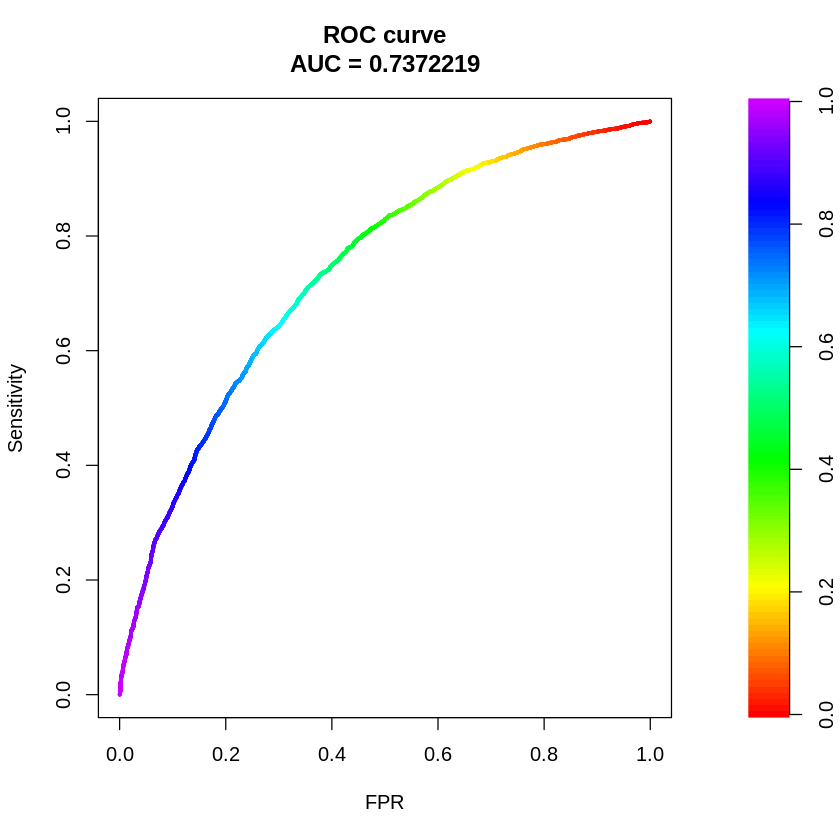

In [ ]:
library(Matrix)
library(MASS)
library(BayesLogit)
library(PRROC)

X <- readMM("/content/X_it_u_mm.mtx")
y <- as.vector(read.csv("/content/y_it_u.csv", header = FALSE)$V1)
X1 <- readMM("/content/X1_it_u_mm.mtx")
y1 <- as.vector(read.csv("/content/y1_it_u.csv", header = FALSE)$V1)

d <- ncol(X)
n <- nrow(X)
r <- 3
N <- 50

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

mu_0 <- 0
mu_w_0 <- 2
lambda_w_0 <- 3
gamma_0 <- 1
alpha_lambda <- 1
beta_lambda <- 1

t <- 1
SaveResults <- matrix(0, N, d + 1 + d * r)
k <- y - 1/2

lambda_w <- rgamma(1, shape = alpha_lambda, rate = beta_lambda)
mu_w <- rnorm(1, mu_0, sqrt(1/(gamma_0 * lambda_w)))
lambda_v <- rgamma(r, shape = alpha_lambda, rate = beta_lambda)
mu_v <- rnorm(r, mu_0, sqrt(1/(gamma_0 * lambda_v)))

Theta_0 <- 0
Theta_w <- rep(0, d)
Theta_v <- rep(0, d * r)
Theta <- c(Theta_0, Theta_w, Theta_v)

Theta_v_matrix <- t(matrix(Theta_v, r, d))

doudle_Sum_Theta <- 0.5 * rowSums(( X %*% Theta_v_matrix)^2 - X^2 %*% Theta_v_matrix^2)

Y <- matrix(Theta_0 + X %*% Theta_w + doudle_Sum_Theta, n, 1)

Q <- X %*% Theta_v_matrix

for (i in 1:N) {
  omega <- rpg(n, 1, Y)

  # Обновление w_0
  sigma_hat_w_0 <- 1 / (sum(omega) + lambda_w_0)
  mu_hat_w_0 <- sigma_hat_w_0 * (lambda_w_0 * mu_w_0 + sum(k) - sum(omega * (Y - Theta_0)))
  w_0_new <- rnorm(1, mu_hat_w_0, sqrt(sigma_hat_w_0))
  Y <- Y + (w_0_new - Theta_0)
  Theta_0 <- w_0_new

  # Обновление w
  for (j in 1:d) {
    sigma_hat_w <- 1 / (sum(omega * X[, j]^2) + lambda_w)
    mu_hat_w <- sigma_hat_w * (lambda_w * mu_w + sum(k * X[, j]) - sum(omega * X[, j] * (Y - Theta_w[j] * X[, j])))
    w_new <- rnorm(1, mu_hat_w, sqrt(sigma_hat_w))
    Y <- Y + (w_new - Theta_w[j]) * X[, j]
    Theta_w[j] <- w_new
  }

  # Обновление v
  for (f in 1:r) {
    for (j in 1:d) {
      h <- X[, j] * Q[, f] - X[, j]^2 * Theta_v_matrix[j, f]
      sigma_hat_v <- 1 / (sum(omega * h^2) + lambda_v[f])
      mu_hat_v <- sigma_hat_v * (lambda_v[f] * mu_v[f] + sum(k * h) - sum(omega * h * (Y - Theta_v_matrix[j, f] * h)))
      v_new <- rnorm(1, mu_hat_v, sqrt(sigma_hat_v))
      Y <- Y + (v_new - Theta_v_matrix[j, f]) * h
      Q[, f] <- Q[, f] + (v_new - Theta_v_matrix[j, f]) * X[, j]
      Theta_v_matrix[j, f] <- v_new
    }
  }
  Theta_v <- c(t(Theta_v_matrix))
  Theta <- c(Theta_0, Theta_w, Theta_v)
  SaveResults[i, ] <- Theta
}

Theta_final <- SaveResults[N, ]
V <- matrix(Theta_final[-(1:(d + 1))], d, r, byrow = TRUE)

D <- 0.5 * rowSums((X1 %*% V)^2 - X1^2 %*% (V^2))
prob <- 1 / (1 + exp(-(Theta_final[1] + X1 %*% Theta_final[2:(d + 1)] + D)))

auc_value <- auroc(prob, y1)
cat("AUROC на тестовом наборе:", auc_value, "\n")

PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0 = y1, curve = TRUE)
plot(PRROC_obj)